In [1]:
import os
from tqdm import tqdm
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.svm import SVC

import seaborn as sns

dataset_path = '../../data/zad3/Gyroscope'

In [2]:
x_raw = []
y_raw = []
for file in tqdm(os.listdir(dataset_path)):
    temp = np.loadtxt(os.path.join(dataset_path, file))
    x_raw.append(temp)
    if 'good' in file:
        y_raw.append(0)
    else:
        y_raw.append(1)
x = np.array(x_raw)
y = np.array(y_raw)

100%|██████████| 604/604 [00:00<00:00, 2325.34it/s]


In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.1)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [4]:
def print_evaluation(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    print(classification_report(y_true, y_pred.round()))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred.round())

    # Plot confusion matrix
    sns.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        36
           1       0.93      1.00      0.96        25

    accuracy                           0.97        61
   macro avg       0.96      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



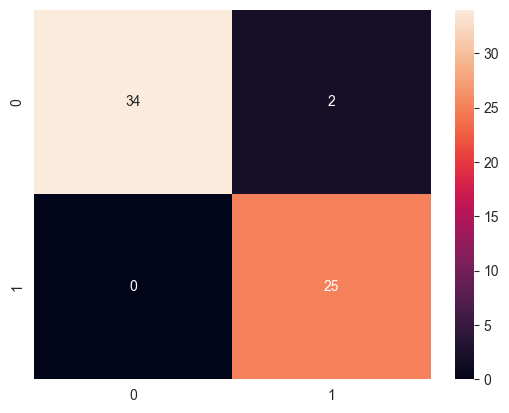

In [5]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True)),
    LSTM(128, input_shape=(10, 1)),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(), loss='bce', metrics=['accuracy'])
model.fit(np.expand_dims(x_train, 2), y_train, epochs=50, verbose=0)
print_evaluation(y_test, model.predict(np.expand_dims(x_test, 2), verbose=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        25

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



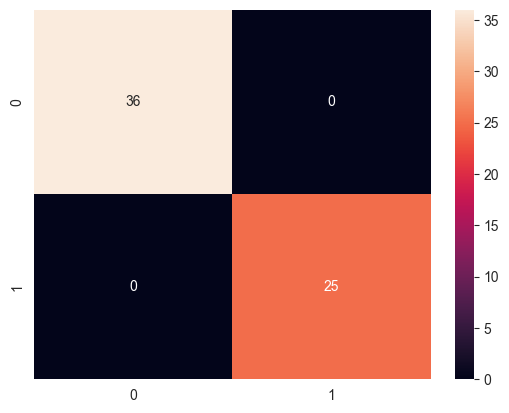

In [6]:
model = Sequential([
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model.compile(optimizer=Adam(), loss='bce', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50, verbose=0)
print_evaluation(y_test, model.predict(x_test, verbose=0))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.96      1.00      0.98        25

    accuracy                           0.98        61
   macro avg       0.98      0.99      0.98        61
weighted avg       0.98      0.98      0.98        61



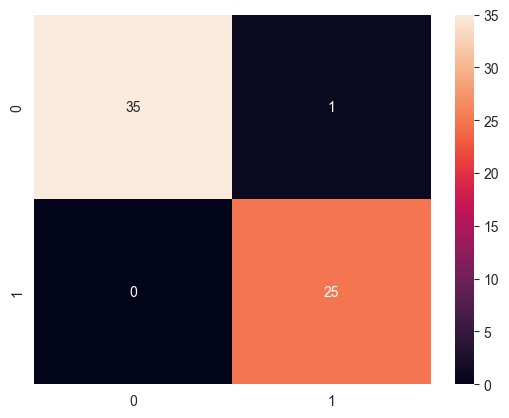

In [7]:
model = Sequential([
    GRU(128, input_shape=(10, 1)),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(), loss='bce', metrics=['accuracy'])
model.fit(np.expand_dims(x_train, 2), y_train, epochs=50, verbose=0)
print_evaluation(y_test, model.predict(np.expand_dims(x_test, 2), verbose=0))

In [8]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
            units=hp.Int("units_1", min_value=32, max_value=512, step=32),
            activation="relu",
        )
    )
    model.add(Dense(
            units=hp.Int("units_2", min_value=32, max_value=512, step=32),
            activation="relu",
        )
    )

    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="adam", loss="bce", metrics=["accuracy"],
    )
    return model

In [9]:
import keras_tuner

In [10]:

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=15,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [12]:
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Trial 15 Complete [00h 00m 08s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 18s
INFO:tensorflow:Oracle triggered exit


In [16]:
model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 352)               45408     
                                                                 
 dense_2 (Dense)             (None, 1)                 353       
                                                                 
Total params: 47,169
Trainable params: 47,169
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        25

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00    

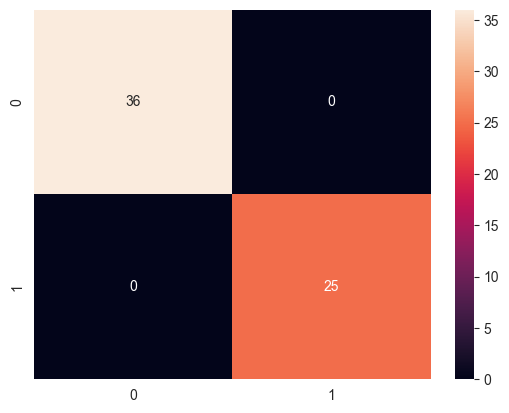

In [20]:
model.build(input_shape=(None, 10))
model.summary()
model.fit(x_train, y_train, verbose=1)
print_evaluation(y_test, model.predict(x_test))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        36
           1       0.92      0.88      0.90        25

    accuracy                           0.92        61
   macro avg       0.92      0.91      0.91        61
weighted avg       0.92      0.92      0.92        61



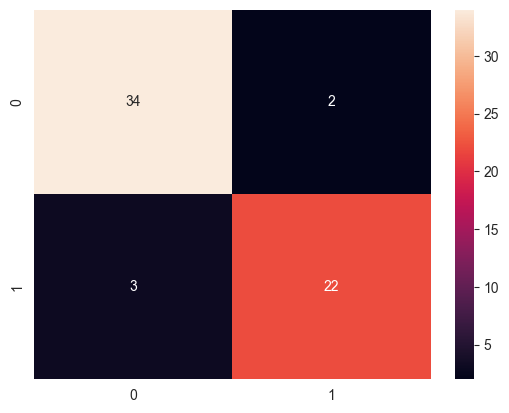

In [13]:
svm = SVC()
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print_evaluation(y_test, y_pred)

--------------------------------------------

In [22]:
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((input_train, input_test), axis=0)
targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True)),
        LSTM(128, input_shape=(10, 1)),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='bce', metrics=['accuracy'])
    model.fit(np.expand_dims(x_train, 2), y_train, epochs=50, verbose=0)
    print_evaluation(y_test, model.predict(np.expand_dims(x_test, 2), verbose=0))


      # # Generate a print
      # print('------------------------------------------------------------------------')
      # print(f'Training for fold {fold_no} ...')
      #
      # # Fit data to model
      # history = model.fit(inputs[train], targets[train],
      #             batch_size=batch_size,
      #             epochs=no_epochs,
      #             verbose=verbosity)

      # Generate generalization metrics
      scores = model.evaluate(inputs[test], targets[test], verbose=0)
      print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
      acc_per_fold.append(scores[1] * 100)
      loss_per_fold.append(scores[0])

      # Increase fold number
      fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')